In [ ]:
# Install packages.
!pip install scispacy
!pip install spacy==3.5.3
!pip install scispacy==0.5.1
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_md-0.5.1.tar.gz
!pip install gensim
!pip install tqdm
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bc5cdr_md-0.5.1.tar.gz

# Import necessary modules
from IPython import get_ipython
from IPython.display import display
from google.colab import drive  # Explicitly import drive
import pandas as pd
import numpy as np
import spacy
import scispacy
from scispacy.linking import EntityLinker
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
import seaborn as sns
from tqdm import tqdm
import re
from google.colab import files # For uploading files
# Mount Google Drive.
try:
    drive.mount('/content/drive', force_remount=True) # Added force_remount
    print("Google Drive mounted successfully!")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")

# Check mounted files
!ls

# Change to the directory you are working in.
%cd drive/MyDrive/AI_in_Healthcare/nlp

# --- Rest of your code ---
# load DIAGNOSES_ICD
diagnoses_icd_df = pd.read_csv('/content/drive/MyDrive/AI_in_Healthcare/nlp/DIAGNOSES_ICD.csv.gz')
diagnoses_icd_df.info()
diagnoses_icd_df.iloc[0]
print(len(diagnoses_icd_df))

# find patients with ICD_CODE 430
arr_subject_id=[]
arr_hadm_id=[]
for row in range(0, len(diagnoses_icd_df)):
  if(diagnoses_icd_df.loc[row, 'ICD9_CODE']=='430'):
    arr_subject_id.append(diagnoses_icd_df.loc[row, 'SUBJECT_ID'])
print('length of array is:',len(arr_subject_id))

# upload NOTEEVENTS
#Method 1 (upload from local machine)
# uploaded = files.upload()
# noteevents_df = pd.read_csv('NOTEEVENTS.csv.gz')

#Method 2 (upload from google drive)
noteevents_df = pd.read_csv('/content/drive/MyDrive/AI_in_Healthcare/nlp/NOTEEVENTS.csv.gz')
noteevents_df.info()
noteevents_df.iloc[0]

# Create dataframe.
icd9_430_patients_discharge_summary_df = pd.DataFrame(columns=['SUBJECT_ID', 'CATEGORY', 'TEXT'])
patients_dict = {"SUBJECT_ID":[],"CATEGORY":[],"TEXT":[]};

for i in range(0, len(noteevents_df)):
  if((noteevents_df.loc[i, 'SUBJECT_ID'] in arr_subject_id) and (noteevents_df.loc[i, 'CATEGORY'] == 'Social Work')):
   patients_dict["SUBJECT_ID"].append(noteevents_df.loc[i, 'SUBJECT_ID'])
   patients_dict["CATEGORY"].append(noteevents_df.loc[i, 'CATEGORY'])
   patients_dict["TEXT"].append(noteevents_df.loc[i, 'TEXT'])

patients_df = pd.DataFrame(patients_dict)
print(patients_df.head(10))
print(patients_df.tail(10))

patients_df.to_csv('ICD9-430_Patients_DischargeSummary.csv', index=False)
patients_df[:10].to_csv('ICD9-430_Patients_DischargeSummary_Top10.csv', index=False)

# Re-import modules just in case the environment was corrupted.
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from collections import Counter
from tqdm import tqdm

# Load the clinical NER model
nlp = spacy.load("en_ner_bc5cdr_md")

# Start of user functions

def extract_medical_entities(text):
    """Extract medical entities using clinical NER model"""
    doc = nlp(text)

    # Extract entities
    entities = {
        'DISEASE': [],
        'CHEMICAL': []
    }

    for ent in doc.ents:
        if len(ent.text) > 3:  # Filter out very short entities
            entities[ent.label_].append(ent.text.lower())

    return entities

def preprocess_text(text):
    """Clean and preprocess the medical text"""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = ' '.join(text.split())
    return text

def create_word_embeddings(texts):
    """Create word embeddings using Word2Vec"""
    sentences = [text.split() for text in texts]
    model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=2)
    return model

def visualize_embeddings(model, entity_type):
    """Create t-SNE visualization of word embeddings"""
    # Get word vectors
    words = list(model.wv.key_to_index.keys())
    if len(words) < 2:  # Need at least 2 words for t-SNE
        print(f"Not enough words for visualization of {entity_type}")
        return

    vectors = [model.wv[word] for word in words]
    # Convert to numpy array
    vectors = np.array(vectors)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(words)-1))
    vectors_tsne = tsne.fit_transform(vectors)

    # Create visualization
    plt.figure(figsize=(12, 8))
    plt.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1], alpha=0.3)

    # Add labels for some points
    for i, word in enumerate(words[:20]):
        plt.annotate(word, (vectors_tsne[i, 0], vectors_tsne[i, 1]))

    plt.title(f'Word Embeddings Visualization - {entity_type}')
    plt.show()

def analyze_medical_notes(notes_df):
    all_entities = {
        'DISEASE': Counter(),
        'CHEMICAL': Counter()
    }

    processed_texts = []

    print("Processing medical notes...")
    for text in tqdm(notes_df['TEXT']):
        # Print sample of entities found (for first few notes)
        if len(processed_texts) < 2:
            print(f"\nSample entities from note {len(processed_texts)+1}:")
            doc = nlp(text[:500])
            for ent in doc.ents:
                print(f"{ent.text}: {ent.label_}")

        cleaned_text = preprocess_text(text)
        processed_texts.append(cleaned_text)
        entities = extract_medical_entities(text[:5000])  # Limit text length

        for entity_type, entity_list in entities.items():
            all_entities[entity_type].update(entity_list)

    # Print found entities
    print("\nEntities found:")
    for entity_type, counter in all_entities.items():
        if counter:
            print(f"\n{entity_type} (top 10):")
            for entity, count in counter.most_common(10):
                print(f"  {entity}: {count}")

    # Create word embeddings
    print("\nTraining Word2Vec model...")
    word2vec_model = create_word_embeddings(processed_texts)

    # Create visualizations
    print("\

SyntaxError: incomplete input (<ipython-input-1-b1fd374862d0>, line 191)

In [ ]:
%ls

 headachenotes.txt                           NOTEEVENTS.csv.gz
 Headache__Patients_DischargeSummary.ipynb  'Screenshot 2025-02-18 at 3.39.23 PM.png'
 Mimic_HW.ipynb                              Word2VECandtSNE.ipynb
 NLP.ipynb


/content


In [ ]:
%cd drive/MyDrive/AI_in_Healthcare/nlp

/content/drive/MyDrive/AI_in_Healthcare/nlp


In [ ]:
!pip install scispacy

In [ ]:
import pandas as pd
import numpy as np
import spacy
import scispacy
from scispacy.linking import EntityLinker
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
import seaborn as sns
from tqdm import tqdm
import re

In [ ]:
!pip install spacy==3.5.3
!pip install scispacy==0.5.1
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_md-0.5.1.tar.gz
!pip install gensim
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.4/917.4 kB 27.7 MB/s eta 0:00:00
  Attempting uninstall: typer
    Found existing installation: typer 0.15.1
    Uninstalling typer-0.15.1:
      Successfully uninstalled typer-0.15.1
  Attempting uninstall: smart-open
    Found existing installation: smart-open 7.1.0
    Uninstalling smart-open-7.1.0:
      Successfully uninstalled smart-open-7.1.0
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.10.6
    Uninstalling pydantic-2.10.6:
      Successfully uninstalled pydantic-2.10.6
  Attempting uninstall: thinc
    Found exis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... canceled
ERROR: Operation cancelled by user
^C
^C
^C
^C


In [ ]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bc5cdr_md-0.5.1.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.2/120.2 MB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached spacy-3.4.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (24 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 107.8 MB/s eta 0:00:00
  Created wheel for en_ner_bc5cdr_md: filename=en_ner_bc5cdr_md-0.5.1-py3-none-any.whl size=120217626 sha256=8deab5e1c5e5c77e41a9f66654c8150c7513a92aa82283080819a36e4b06180b
  Stored in directory: /root/.cache/pip/wheels/b4/8d/fb/36403b97e0de3d4c3f81c95f9d22c423d90f542243a35d5350
Successfully built en_ner_bc5cdr_md
  Attempting uninstall: wasabi
    Found existing installation: wasabi 1.1.3
    Uninstalling wasabi-1.1.3:
      Successfully uninstalled wasabi-1.1.3
  Attempting uninstall: spacy
    Found existing installation: spacy 3.5.3
    Uninstalling spacy-3.5.3:
      Successfully uninstalled spacy-3.5.3
ERROR: pip's dependency resolver does not currently take into account all the p

# **Start by uploading the DIAGNOSES_ICD file and getting all patients for ICD_CODE=430**

In [ ]:
import pandas as pd
diagnoses_icd_df = pd.read_csv('/content/DIAGNOSES_ICD.csv.gz')
diagnoses_icd_df.info()
diagnoses_icd_df.iloc[0]
print(len(diagnoses_icd_df))

FileNotFoundError: [Errno 2] No such file or directory: '/content/DIAGNOSES_ICD.csv.gz'

In [ ]:
arr_subject_id=[]
arr_hadm_id=[]
for row in range(0, len(diagnoses_icd_df)):
  if(diagnoses_icd_df.loc[row, 'ICD9_CODE']=='430'):
    arr_subject_id.append(diagnoses_icd_df.loc[row, 'SUBJECT_ID'])

    # print(diagnoses_icd_df.loc[row, 'SUBJECT_ID'])
print('length of array is:',len(arr_subject_id))

NameError: name 'diagnoses_icd_df' is not defined

# **You can use one of the following ways to upload the NOTEEVENTS or any file in colab**

# **Method:1**

In [ ]:
# upload file from local drive and open it for reading (NOTEEVENTS file)
from google.colab import files
uploaded = files.upload()

MessageError: TypeError: Cannot read properties of undefined (reading 'next')

In [ ]:
# read the uploaded file in a dataframe
noteevents_df = pd.read_csv('NOTEEVENTS.csv.gz')

FileNotFoundError: [Errno 2] No such file or directory: 'NOTEEVENTS.csv.gz'

# **Method:2**

In [ ]:
noteevents_df = pd.read_csv('/content/NOTEEVENTS.csv.gz')
noteevents_df.info()
noteevents_df.iloc[0]

<ipython-input-9-6c8bfc549b8b>:1: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  noteevents_df = pd.read_csv('/content/NOTEEVENTS.csv.gz')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2083180 entries, 0 to 2083179
Data columns (total 11 columns):
 #   Column       Dtype  
---  ------       -----  
 0   ROW_ID       int64  
 1   SUBJECT_ID   int64  
 2   HADM_ID      float64
 3   CHARTDATE    object 
 4   CHARTTIME    object 
 5   STORETIME    object 
 6   CATEGORY     object 
 7   DESCRIPTION  object 
 8   CGID         float64
 9   ISERROR      float64
 10  TEXT         object 
dtypes: float64(3), int64(2), object(6)
memory usage: 174.8+ MB


,0
ROW_ID,174
SUBJECT_ID,22532
HADM_ID,167853.0
CHARTDATE,2151-08-04
CHARTTIME,NaN
STORETIME,NaN
CATEGORY,Discharge summary
DESCRIPTION,Report
CGID,NaN
ISERROR,NaN


# **Filter the data in files to create a new relevant dataframe**

In [ ]:
icd9_430_patients_discharge_summary_df = pd.DataFrame(columns=['SUBJECT_ID', 'CATEGORY', 'TEXT'])
patients_dict = {"SUBJECT_ID":[],"CATEGORY":[],"TEXT":[]};

In [ ]:
for i in range(0, len(noteevents_df)):
  if((noteevents_df.loc[i, 'SUBJECT_ID'] in arr_subject_id) and (noteevents_df.loc[i, 'CATEGORY'] == 'Social Work')):
   patients_dict["SUBJECT_ID"].append(noteevents_df.loc[i, 'SUBJECT_ID'])
   patients_dict["CATEGORY"].append(noteevents_df.loc[i, 'CATEGORY'])
   patients_dict["TEXT"].append(noteevents_df.loc[i, 'TEXT'])

In [ ]:
patients_df = pd.DataFrame(patients_dict)
# Display top and bottom 10 rows
print(patients_df.head(10))
print(patients_df.tail(10))

# Save the dataframe to CSV or Excel format
patients_df.to_csv('ICD9-430_Patients_DischargeSummary.csv', index=False)
patients_df[:10].to_csv('ICD9-430_Patients_DischargeSummary_Top10.csv', index=False)


   SUBJECT_ID     CATEGORY                                               TEXT
0       22933  Social Work  Family Information\n   Next of [**Doctor First...
1       22933  Social Work  Family Information\n   Next of [**Doctor First...
2       22933  Social Work  Family Information\n   Next of [**Doctor First...
3       30829  Social Work  Social Work:\n   Pt is 61 yr-old gentleman adm...
4        6884  Social Work  SW Note:\n   This worker has participated in t...
5       79358  Social Work  Family meeting held on [**2192-12-7**], presen...
6       79358  Social Work  Family Information\n   Next of [**Doctor First...
7       88012  Social Work  Family Information\n   Next of [**Doctor First...
8       53639  Social Work  Family Information\n   Next of [**Doctor First...
9       89909  Social Work  Family meeting held yesterday with NP from Neu...
    SUBJECT_ID     CATEGORY                                               TEXT
57       71059  Social Work  Continuing to work with patients [

In [ ]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from collections import Counter
from tqdm import tqdm

# Load the clinical NER model
nlp = spacy.load("en_ner_bc5cdr_md")

Processing medical notes...


  1%|▏         | 1/67 [00:00<00:11,  5.91it/s]


Sample entities from note 1:
NO: CHEMICAL

Sample entities from note 2:


100%|██████████| 67/67 [00:04<00:00, 16.06it/s]



Entities found:

DISEASE (top 10):
  psychiatric: 17
  aneurysm: 6
  pain: 4
  anxiety: 4
  headache: 4
  trauma: 4
  traumatic: 3
  death: 3
  vomiting: 2
  disability: 2

CHEMICAL (top 10):
  cocaine: 2
  etoh: 2
  fa10: 1
  10113: 1
  dhmc: 1
  alcohol: 1

Training Word2Vec model...

Creating visualizations...


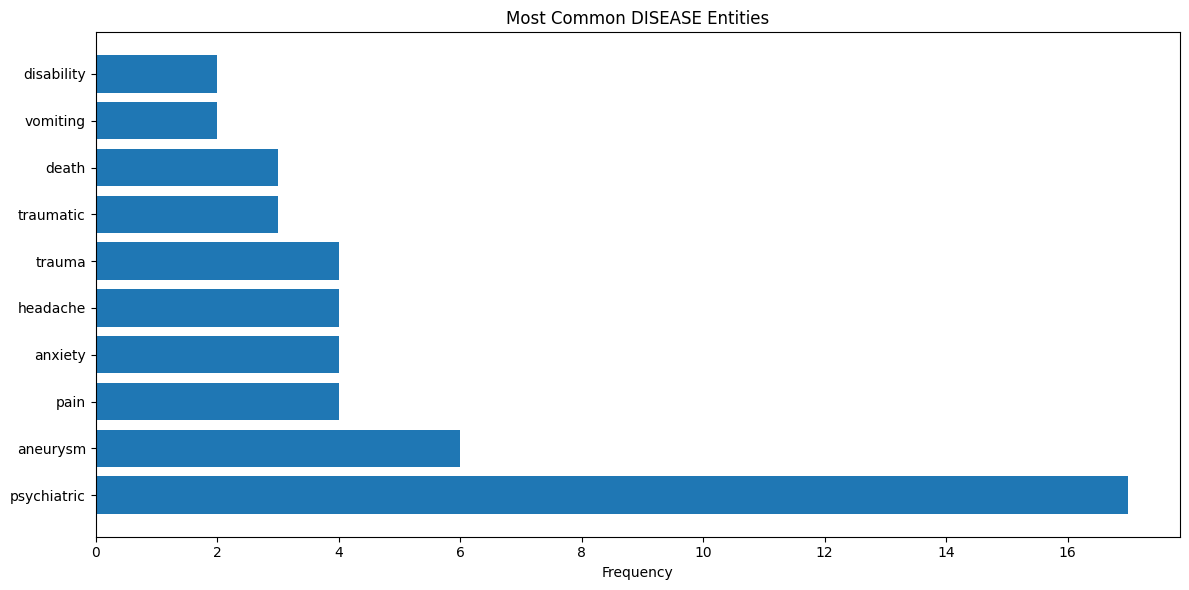

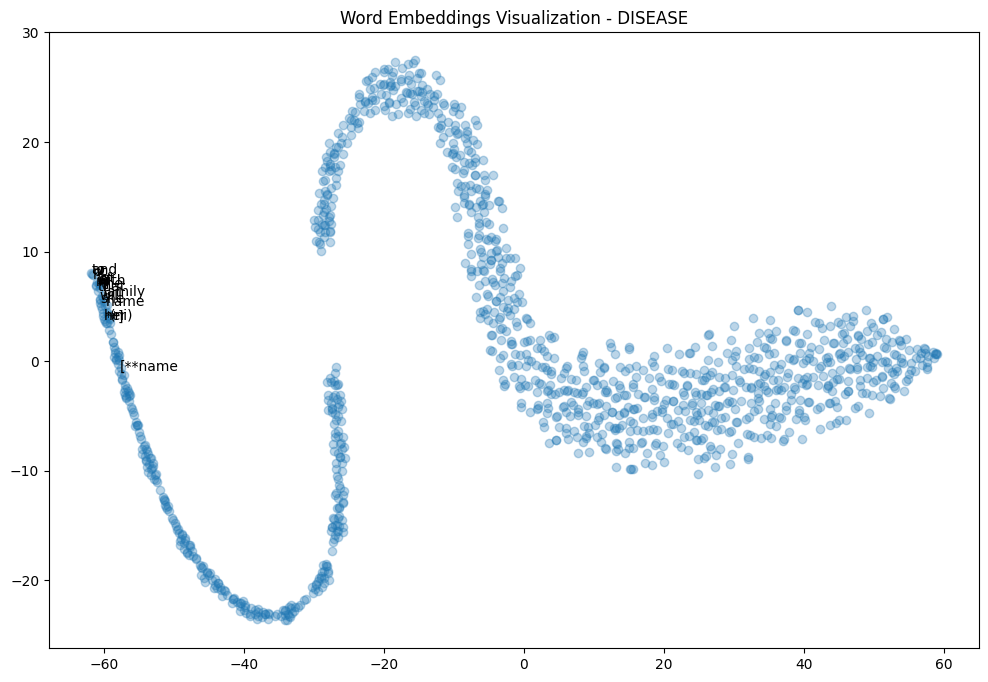

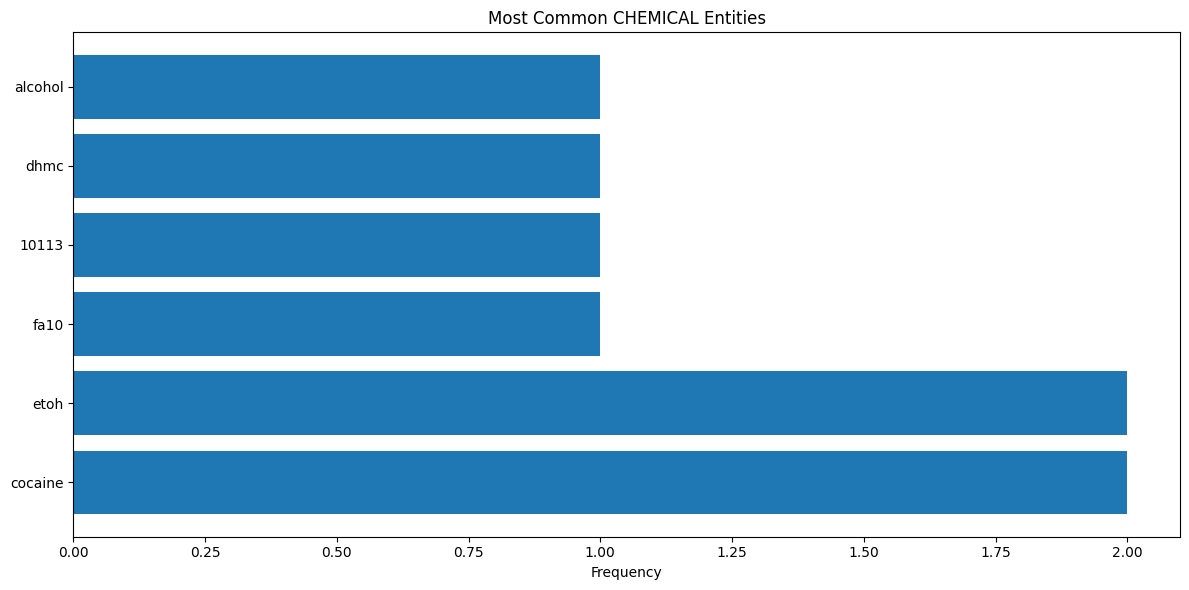

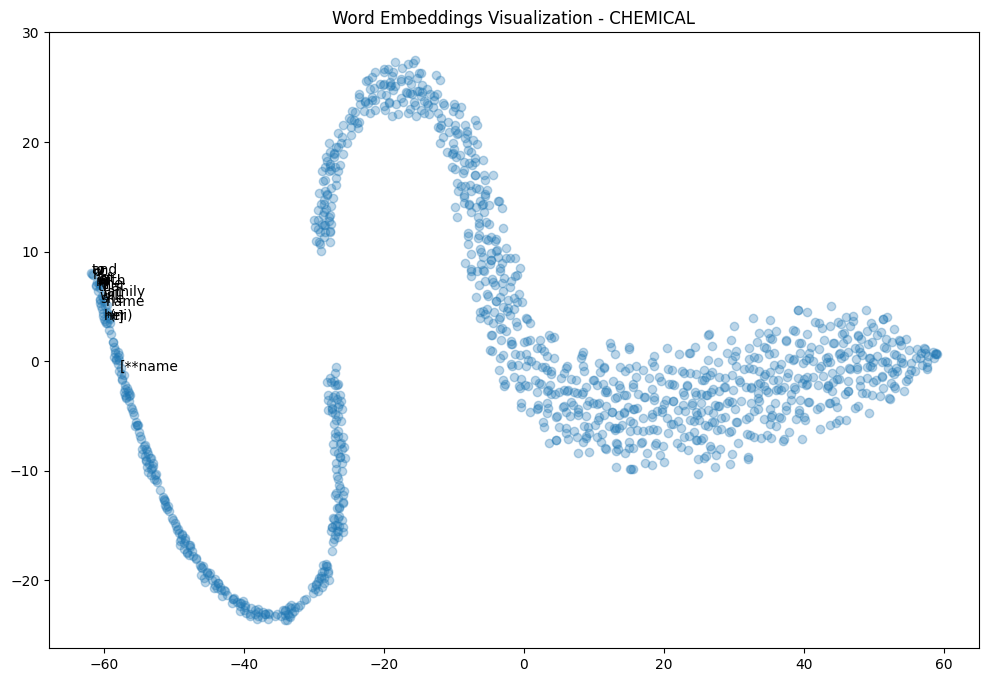

In [ ]:
def extract_medical_entities(text):
    """Extract medical entities using clinical NER model"""
    doc = nlp(text)

    # Extract entities
    entities = {
        'DISEASE': [],
        'CHEMICAL': []
    }as

    for ent in doc.ents:
        if len(ent.text) > 3:  # Filter out very short entities
            entities[ent.label_].append(ent.text.lower())

    return entities

def preprocess_text(text):
    """Clean and preprocess the medical text"""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = ' '.join(text.split())
    return text

def create_word_embeddings(texts):
    """Create word embeddings using Word2Vec"""
    sentences = [text.split() for text in texts]
    model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=2)
    return model

def visualize_embeddings(model, entity_type):
    """Create t-SNE visualization of word embeddings"""
    # Get word vectors
    words = list(model.wv.key_to_index.keys())
    if len(words) < 2:  # Need at least 2 words for t-SNE
        print(f"Not enough words for visualization of {entity_type}")
        return

    vectors = [model.wv[word] for word in words]
    # Convert to numpy array
    vectors = np.array(vectors)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(words)-1))
    vectors_tsne = tsne.fit_transform(vectors)

    # Create visualization
    plt.figure(figsize=(12, 8))
    plt.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1], alpha=0.3)

    # Add labels for some points
    for i, word in enumerate(words[:20]):
        plt.annotate(word, (vectors_tsne[i, 0], vectors_tsne[i, 1]))

    plt.title(f'Word Embeddings Visualization - {entity_type}')
    plt.show()

def analyze_medical_notes(notes_df):
    all_entities = {
        'DISEASE': Counter(),
        'CHEMICAL': Counter()
    }

    processed_texts = []

    print("Processing medical notes...")
    for text in tqdm(notes_df['TEXT']):
        # Print sample of entities found (for first few notes)
        if len(processed_texts) < 2:
            print(f"\nSample entities from note {len(processed_texts)+1}:")
            doc = nlp(text[:500])
            for ent in doc.ents:
                print(f"{ent.text}: {ent.label_}")

        cleaned_text = preprocess_text(text)
        processed_texts.append(cleaned_text)
        entities = extract_medical_entities(text[:5000])  # Limit text length

        for entity_type, entity_list in entities.items():
            all_entities[entity_type].update(entity_list)

    # Print found entities
    print("\nEntities found:")
    for entity_type, counter in all_entities.items():
        if counter:
            print(f"\n{entity_type} (top 10):")
            for entity, count in counter.most_common(10):
                print(f"  {entity}: {count}")

    # Create word embeddings
    print("\nTraining Word2Vec model...")
    word2vec_model = create_word_embeddings(processed_texts)

    # Create visualizations
    print("\nCreating visualizations...")
    for entity_type in all_entities.keys():
        if all_entities[entity_type]:
            plt.figure(figsize=(12, 6))
            entity_counts = all_entities[entity_type].most_common(10)
            if entity_counts:
                entities, counts = zip(*entity_counts)
                plt.barh(entities, counts)
                plt.title(f'Most Common {entity_type} Entities')
                plt.xlabel('Frequency')
                plt.tight_layout()
                plt.show()

                visualize_embeddings(word2vec_model, entity_type)

    return all_entities, word2vec_model

# Run the analysis
entities, model = analyze_medical_notes(patients_df)

Family Information
   Next of [**Doctor First Name **]: [**Name (NI) 326**] [**Name (NI) 484**], husband
   Health [**Name (NI) **] Proxy appointed: Yes - But NO copy of signed proxy form in
   medical record
   Family Spokesperson designated: [**Name (NI) 326**] [**Name (NI) 484**], husband: c:
   [**Telephone/Fax (1) 6221**], h: [**Telephone/Fax (1) 6961**]
   Communication or visitation restriction: none
   Patient Information:
   Previous living situation: Home w/ others
   Previous level of
Processing medical notes...


 20%|██        | 1/5 [00:00<00:00,  7.04it/s]


Found entities:
family: ENTITY
doctor: ENTITY
copy of signed: ENTITY
medical record: ENTITY
family spokesperson: ENTITY

Found entities:
family: ENTITY
doctor: ENTITY
appointed: ENTITY
husband name ni appointed name ni family spokesperson: ENTITY
husband communication: ENTITY


100%|██████████| 5/5 [00:00<00:00, 14.55it/s]


Found entities:
family: ENTITY
doctor: ENTITY
husband name ni health care: ENTITY
appointed family spokesperson: ENTITY
husband name ni communication: ENTITY

Found entities:
social work: ENTITY
yrold: ENTITY
gentleman: ENTITY
whypotension: ENTITY
omr: ENTITY

Found entities:
worker: ENTITY
family meetings: ENTITY
namepattern: ENTITY
namepattern: ENTITY
family members: ENTITY

Entities found:

Training Word2Vec model...

Creating visualizations...


In [ ]:
print("\nEntity Statistics:")
for entity_type, counter in entities.items():
    if counter:
        print(f"\nTop 10 {entity_type} entities:")
        for entity, count in counter.most_common(10):
            print(f"{entity}: {count}")


Entity Statistics:


In [ ]:
from google.colab import drive
drive.mount('/content/drive')